
The project  consists of three classes: the GridWorld; the GridRules and the Agent.


The Gridworld class has two variables: two different tracks defined as 2D character numpy arrays. The two tracks correspond to the two configurations of the maze in the problem




The GridRules class defines the rules that govern how the agents moves in the maze. It takes two arguments: and instance of the GridWorld class; and an integer specifying the identity of the maze initially used in the GridWorld class.




Agent class defines the structure of the agent. It has two important functions: “run_episode_DaynaQ_ex”  which implements the Alternate Method referenced in the problem set and “run_episode_DaynaQpve” which implements the DynaQ+ method.  This functions return the optimal sequence of actions after each episode. This class takes three arguments: GridRules class; the value for epsilon; the value of the learning rate; the discount value; the initial values for the state-actions pairs, the number of planning steps, and the value of the constant for the bonus reward. The function “show_agent_sequence” displays the path traversed by the agent in the maze.




The notebook’s cells should be run in sequential order and the parameters such as epsilon; number of episodes, learning rate, planning steps, etc can be adjusted accordingly. The output of the entire program is a cmap of the paths taken by the agent and plot of the cumulative reward vs steps and the steps per episode vs the episodes


In [ ]:
# Data structures packages
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import math


# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick

In [ ]:
class gridWorld:
    maze_1 = np.array([

                ['t','t','t','t','t','t','t','t','G'],
                ['t','t','t','t','t','t','t','t','t'],
                ['t','t','t','t','t','t','t','t','t'],
                ['t','B','B','B','B','B','B','B','B'],
                ['t','t','t','t','t','t','t','t','t'],
                ['t','t','t','S','t','t','t','t','t'],

              ])

    maze_2 = np.array([

                ['t','t','t','t','t','t','t','t','G'],
                ['t','t','t','t','t','t','t','t','t'],
                ['t','t','t','t','t','t','t','t','t'],
                ['t','B','B','B','B','B','B','B','t'],
                ['t','t','t','t','t','t','t','t','t'],
                ['t','t','t','S','t','t','t','t','t'],

              ])



In [ ]:
class gridRules:

    # Constants
    VALID_MOVE_REWARD = 0
    INVALID_MOVE_REWARD = 0
    GOAL_REWARD = 5

    # description of cell values
    OPEN_VALUE = 't'
    BOUNDS_VALUE = 'B'
    START_VALUE = 'S'
    GOAL_VALUE = 'G'
    AGENT_VALUE = 'A'

    def __init__(self, maze, maze_num):

        #initialize maze
        self.maze = maze
        self.finished = False
        self.RAND_POS_CHANGE_PROBABILITY = 0.5 # Experimental scenario (randomly void an action taken by the agent)

        if maze_num == 1:
            self.maze_type = self.maze.maze_1
        elif track_num == 2:
            self.maze_type = self.maze.maze_2

        self.position = self.get_start_position()


    # get the location of the character 'S' in the maze
    def get_start_position(self):

        x_coordinates, y_coordinates = np.where(self.maze_type == self.START_VALUE)

        return (x_coordinates[0], y_coordinates[0])


    # Move agent
    def update_position(self, action):

        self.position = (self.position[0] + action[0], self.position[1] + action[1])

    # ensure agent is not out-of-bounds; return true if so, else false
    def check_out_of_bounds(self):

        boundry = self.position[0] < 0 or self.position[0] >= self.maze_type.shape[0] or \
        self.position[1] < 0 or self.position[1] >= self.maze_type.shape[1]

        if boundry:
            return True
        elif self.maze_type[self.position] == self.BOUNDS_VALUE:
            return True
        else:
            return False



    # Reset agent's position at the end of every episode
    def reset_agent_state(self):

        self.position = self.get_start_position()
        self.finished = False

    # Return the state of the agent
    def get_agent_state(self):

        return (self.position[0], self.position[1])

    # Check if agent has reached one of the end locations Return true if so, else return False
    def check_finish(self, last_state):

        if self.check_out_of_bounds():
            self.position = last_state

        if self.maze_type[self.position] == self.GOAL_VALUE:
            return True
        else:
            return False


    # change the configuration of the maze
    def change_maze(self,maze_number):

        if maze_number == 1:
            self.maze_type = self.maze.maze_1
        elif maze_number == 2:
            self.maze_type = self.maze.maze_2


    # Move Agent
    def move_agent(self, x_move, y_move):

        assert not self.finished

        last_position = self.position

        # Comment out this line to run the experimental scenario
        self.update_position((x_move, y_move))


        #Uncomment this if-else section of code to run the experimental scenario
        # if np.random.uniform(0, 1) < self.RAND_POS_CHANGE_PROBABILITY:
        #     self.update_position((0, 0))

        # else:
        #     self.update_position((x_move, y_move))

        # Check if finished
        if self.check_finish(last_position):
            self.finished = True
            print("Agent has found goal!")
            return self.GOAL_REWARD

        # Check for invalid position
        invalid_position = False

        if self.check_out_of_bounds():
            invalid_position = True
            self.position = last_position

        # Check if finished again
        if self.check_finish(last_position):
            self.finished = True

            if invalid_position:
                self.position = last_position
                return self.INVALID_MOVE_REWARD
            else:
                return self.VALID_MOVE_REWARD

        if invalid_position:
            self.position = last_position
            return self.INVALID_MOVE_REWARD
        else:
            return self.VALID_MOVE_REWARD



In [ ]:
class Agent:

    ACTIONS_DIM = 4
    ACTIONS = [[0, 1], [1, 0], [-1, 0], [0, -1]]

    # Initialize agent
    def __init__(self, rules, epsilon, alpha, discount, init, n, k):
        self.rules = rules
        self.epsilon = epsilon
        self.init = init
        self.alpha = alpha
        self.discount_factor = discount
        self.k = k
        self.n = n

        self.state_action_values = None
        self.state_action_time_elasped = None
        # self.state_action_bonus = None
        self.state_action_counts = None
        self.model = None
        self.policy = None
        self.no_steps = 0
        self.tried_state_actions = []
        self.cumulative_rewards = []
        self.cum_reward = 0
        self.reset()


    # Run episode for traditional DynaQ+
    def run_episode_DaynaQpve(self):

        sequence = [] #save state-action sequence

        while not self.rules.finished:

            state = self.rules.get_agent_state()

            if self.no_steps == 1000:

                self.rules.change_maze(2)

            self.no_steps += 1

            self.update_policy()

            action = self.epsilon_explore(self.policy[state])

            reward = self.rules.move_agent(*self.action_to_move(action))

            sequence.append((state, action, reward))

            self.cum_reward = self.cum_reward + reward

            self.cumulative_rewards.append(self.cum_reward)    # store cumulative reward

            next_state = self.rules.get_agent_state() # save the next state resulting from a state action pair

            state_action = state + (action,)


            #save actions that have been tried for model learning
            if state_action not in self.tried_state_actions:
                self.tried_state_actions.append(state_action)

            # update state-action values using DynaQ
            self.state_action_values[state_action] = self.state_action_values[state_action] + \
            self.alpha * (reward + (self.discount_factor*self.max_state_action(state)) + self.state_action_values[state_action])

            #calculate the number of steps that have elapsed since the action was last tried
            time_past = self.no_steps - self.state_action_time_elasped[state_action]

            # register this state-action pair as recently tried
            self.state_action_time_elasped[state_action] = self.no_steps

            # calculate model's reward according to DynaQ+
            model_reward = reward + self.k*math.sqrt(time_past)

            # save this Reward and proceeding state in the model
            self.model[state_action] = (model_reward,) + next_state + (action,)

            for i in range(0, self.n):

                # randomly select a state-action pair from the list of tried state-action pairs
                init_s1, init_s2, init_A = self.rand_select_state_action()

                # get the model's reward and next state values for the selected state-action pair
                R,S1,S2,A = self.model[(init_s1, init_s2, init_A)]

                # indirect learning according to DynaQ
                self.state_action_values[(init_s1,init_s2,init_A)] = self.state_action_values[(init_s1,init_s2,init_A)] + \
                self.alpha * (R + (self.discount_factor*self.max_state_action_ex((S1,S2,A))) - self.state_action_values[(init_s1,init_s2,init_A)])

        return sequence


    def run_episode_DaynaQ_ex(self):

        sequence = [] #save state-action sequence

        while not self.rules.finished:

            state = self.rules.get_agent_state()

            if self.no_steps == 1000:

                self.rules.change_maze(2)


            self.no_steps += 1

            self.update_policy_ex()

            action = self.epsilon_explore(self.policy[state])

            reward = self.rules.move_agent(*self.action_to_move(action))

            self.cum_reward = self.cum_reward + reward

            self.cumulative_rewards.append(self.cum_reward)

            sequence.append((state, action, reward))

            next_state = self.rules.get_agent_state()

            state_action = state + (action,)

            # save actions that have been tried for model learning
            if state_action not in self.tried_state_actions:
                self.tried_state_actions.append(state_action)

            # update state-action values using DynaQ
            self.state_action_values[state_action] = self.state_action_values[state_action] + \
            self.alpha * (reward + (self.discount_factor*self.max_state_action_ex(next_state)) + self.state_action_values[state_action])

            # register this state-action pair as recently tried
            self.state_action_time_elasped[state_action] = self.no_steps

            # save this Reward and proceeding state in the model
            self.model[state_action] = (reward,) + next_state + (action,)

            for i in range(0, self.n):

                # randomly select a state-action pair from the list of tried state-action pairs
                init_s1, init_s2, init_A = self.rand_select_state_action()

                # get the model's reward and next state values for the selected state-action pair
                R,S1,S2,A = self.model[(init_s1, init_s2, init_A)]

                # indirect learning according to DynaQ
                self.state_action_values[(init_s1,init_s2,init_A)] = self.state_action_values[(init_s1,init_s2,init_A)] + \
                self.alpha * (R + (self.discount_factor*self.max_state_action_ex((S1,S2,A))) - self.state_action_values[(init_s1,init_s2,init_A)])


        return sequence

    # Create array of zeros for policy, state-action values
    def reset(self):

        self.state_action_values = np.zeros((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1], self.ACTIONS_DIM), dtype=np.float32) - self.init

        #self.state_action_counts = np.zeros((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1], self.ACTIONS_DIM),dtype=np.int32)

        # initialize
        #self.state_action_bonus = np.zeros((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1], self.ACTIONS_DIM), dtype=np.float32)

        # initialize model
        self.model = np.empty((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1], self.ACTIONS_DIM),dtype=object)

        # initialize array to keep track of how recently state-action pairs have been tried
        self.state_action_time_elasped = np.zeros((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1], self.ACTIONS_DIM),dtype=np.float32)

        self.policy = np.zeros((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1]),dtype=np.int32)


    # select actions with maximum bonus reward for each state (used in the function implementing the alternate method)
    def update_policy_ex(self):

        bonus_state_action_reward = self.state_action_values + self.k*np.sqrt(self.no_steps - self.state_action_time_elasped)

        self.policy = np.argmax(bonus_state_action_reward, axis=-1)

    # select actions with maximum reward for each state
    def update_policy(self):

        self.policy = np.argmax(self.state_action_values, axis=-1)

    # get max state-action value for given state
    def max_state_action(self, state):

        return max([self.state_action_values[state[0]][state[1]][0], self.state_action_values[state[0]][state[1]][1],
                    self.state_action_values[state[0]][state[1]][2], self.state_action_values[state[0]][state[1]][3]])


    # get max state-action value for given state for the alternate method
    def max_state_action_ex(self, state):

        # get the bonus reward plus reward for all states-action pairs
        bonus_state_action_reward = self.state_action_values + self.k*np.sqrt(self.no_steps - self.state_action_time_elasped)

        # return the action with the highest bonus reward plus reward for the given state
        return max([bonus_state_action_reward[state[0]][state[1]][0], bonus_state_action_reward[state[0]][state[1]][1],
                    bonus_state_action_reward[state[0]][state[1]][2], bonus_state_action_reward[state[0]][state[1]][3]])

    # Selected one of the 4 possible actions
    def action_to_move(self, action_index):

        return self.ACTIONS[action_index]


    # Choose random action with a probability of self.epsilon
    def epsilon_explore(self, action):

        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, self.ACTIONS_DIM)
        else:
            return action

    # reset the number of steps at the end of each episode
    def reset_no_steps(self):

        self.no_steps = 0
        self.state_action_time_elasped = np.zeros((self.rules.maze_type.shape[0], self.rules.maze_type.shape[1], self.ACTIONS_DIM),dtype=np.float32)


    # Randomly select a state-action pair from the list of tried state-actions
    def rand_select_state_action(self):

        s_a = np.random.randint(0,len(self.tried_state_actions))

        return self.tried_state_actions[s_a]


    # Display the actions the agent took in the maze
    def show_agent_sequence(self, sequence):

        # Convert possible track values to distinct integers for cmap
        START_VALUE = ord('S')%7
        GOAL_VALUE = ord('G')%7
        PATH_VALUE = ord('t')%7
        BOUNDS_VALUE = ord('B')%7
        AGENT_VALUE = ord('A')%7

        maze = self.rules.maze_type.copy()

        #
        for item in sequence:
            state = item[0]
            maze[state[0], state[1]] = 'A'

        maze = maze.tolist()

        # convert track characters to ascii and then to distinct integers
        for i in range(0,len(maze)):
            for j in range(0, len(maze[0])):
                maze[i][j] = ord(maze[i][j])%7

        maze = np.array(maze)

        im = plt.imshow(maze)

        plt.axis("off")

        values = np.unique(maze.ravel())
        labels = {
          START_VALUE: "Start",
          GOAL_VALUE: "Finish",
          PATH_VALUE: "Open Path",
          BOUNDS_VALUE: "Boundry",
          AGENT_VALUE: "Agent"
        }
        colors = [im.cmap(im.norm(value)) for value in values]
        patches = [mpatches.Patch(color=colors[i], label=labels[values[i]]) for i in range(len(values))]
        plt.legend(handles=patches, loc=4)

        plt.show()



In [ ]:
# run episodes this cell for Alternate Method

episodes = 50

grid = gridWorld() # instance of maze used by agent
maze = gridRules(grid,1) # instance of class setting the rules for agent
solver = Agent(maze, 0.2, 0.2, 0.4, 0, 10, 0.1) # instance of Agent def __init__(self, rules, epsilon, alpha, discount, init, n, k)

no_steps = []
for i in range(episodes):
    s = solver.run_episode_DaynaQ_ex()
    no_steps.append(solver.no_steps)
    solver.reset_no_steps()
    maze.reset_agent_state()



solver.show_agent_sequence(s)

In [ ]:
# run episodes and print out sequence of agent actions in cmap (tried discount factor 0.8)

episodes = 50

grid = gridWorld() # instance of maze used by agent
maze = gridRules(grid,1) # instance of class setting the rules for agent
solver = Agent(maze, 0.2, 0.2, 0.4, 0, 10, 0.1) # instance of Agent def __init__(self, rules, epsilon, alpha, discount, init, n, k)


no_steps = []
for i in range(episodes):
    s = solver.run_episode_DaynaQpve()
    no_steps.append(solver.no_steps)
    solver.reset_no_steps()
    maze.reset_agent_state()



solver.show_agent_sequence(s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0, 0.5, 'No of Steps')

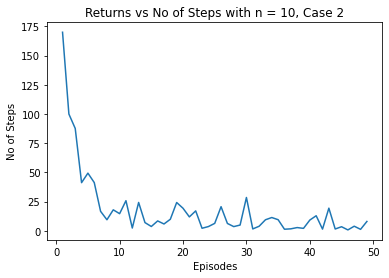

In [ ]:
ep = np.arange(episodes)
s_e = np.array(no_steps)/ep

plt.plot(ep, s_e)
plt.title('Returns vs No of Steps with n = 10')
plt.xlabel('Episodes')
plt.ylabel('No of Steps')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Average Reward')

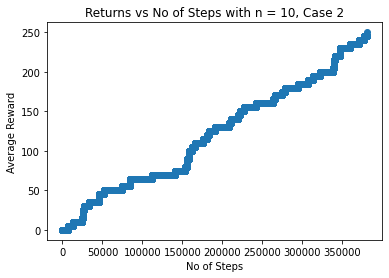

In [ ]:
stepss = np.cumsum(no_steps)
stps = np.arange(stepss[49])
cumulative_average_reward = solver.cumulative_rewards / stps
plt.scatter(stps, solver.cumulative_rewards)
plt.title('Returns vs No of Steps with n = 10, Case 2')
plt.xlabel('No of Steps')
plt.ylabel('Average Reward')